In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

In [2]:
# define the input directory
input_dir = '/Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-modeling/project/input'

In [3]:
data_folder = '/Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-modeling/project/data'

In [4]:
import sys
sys.path.append("/Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-modeling/project/eccoseas")
from ecco import grid

In [5]:
ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

In [6]:
# define the parameters that will be used in the data file
delX = 0.25
delY = 0.25
xgOrigin = 55
ygOrigin = -20
n_rows = 280
n_cols = 160

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'India_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [7]:
from downscale import hFac

In [8]:
depth = bathy
delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50,])
hFacC = hFac.create_hFacC_grid(depth, delR)

In [9]:
mask = np.copy(hFacC)
mask[mask>0] = 1

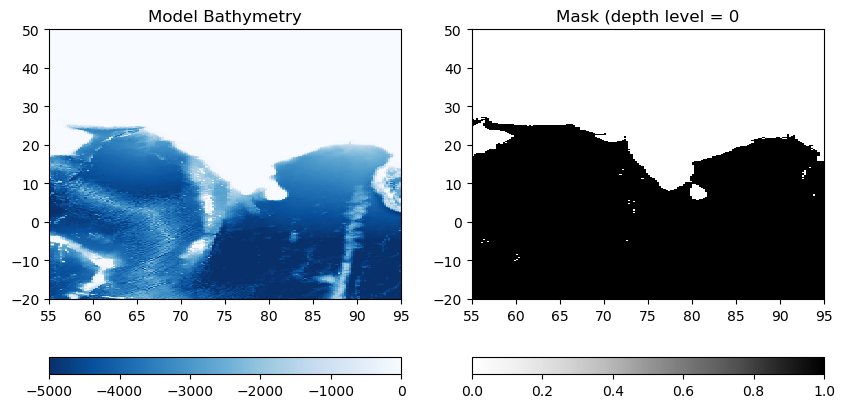

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

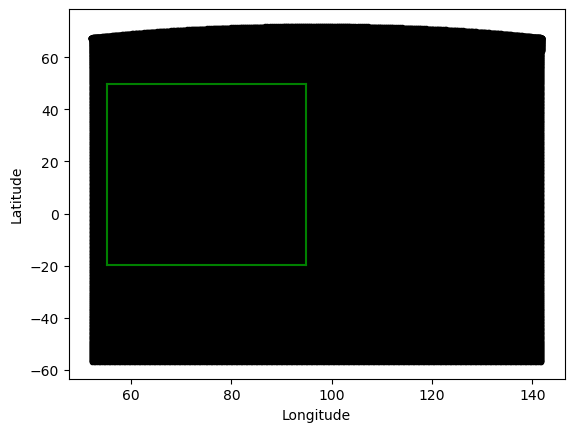

In [11]:
# plot the ECCO tile points from tiles 8 and 11
plt.plot(ecco_XC_tiles[6],ecco_YC_tiles[6],'k.')
plt.plot(ecco_XC_tiles[5],ecco_YC_tiles[5],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
tile_list = [5,6]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_mask_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_mask_points = ecco_mask_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

In [13]:
# make a file dictionary to loop over

# test dictionary
# file_prefix_dict = {'ETAN':'ETAN_2008.nc'}
# file_prefix_dict = {'THETA':'THETA_1997.nc'}

# once tested with the above dict, run and comment with this one
file_prefix_dict = {'ETAN':'ETAN_1996.nc',
                    'THETA':'THETA_1996.nc',
                    'SALT':'SALT_1996.nc',
                    'UVELMASS':'UVELMASS_1996.nc',
                    'VVELMASS':'VVELMASS_1996.nc',
                    'WVELMASS':'WVELMASS_1996.nc',
                    'MXLDEPTH':'MXLDEPTH_1996.nc'}
variable_names = list(file_prefix_dict.keys())

In [14]:
init_grids = []

tile_list = [5, 6]  # ECCO tile numbers
tile_indices = [t - 1 for t in tile_list]  # Python 0-based index

for variable_name in variable_names:
    print(f"\nProcessing {variable_name}...")

    file_path = os.path.join(data_folder, file_prefix_dict[variable_name])
    with nc4.Dataset(file_path) as ds:
        grid_data = ds.variables[variable_name][:]

    if variable_name in ['UVELMASS', 'VVELMASS', 'WVELMASS']:
        with nc4.Dataset(os.path.join(data_folder, 'UVELMASS_1996.nc')) as ds_u:
            u_grid = ds_u.variables['UVELMASS'][:, :, tile_indices, :, :]
        with nc4.Dataset(os.path.join(data_folder, 'VVELMASS_1996.nc')) as ds_v:
            v_grid = ds_v.variables['VVELMASS'][:, :, tile_indices, :, :]
        with nc4.Dataset(os.path.join(data_folder, 'WVELMASS_1996.nc')) as ds_w:
            w_grid = ds_w.variables['WVELMASS'][:, :, tile_indices, :, :]

    nz = grid_data.shape[1] if grid_data.ndim == 5 else 1
    tile_grids = []

    for local_idx, tile_number in enumerate(tile_indices):  
        for k in range(nz):
            if variable_name in ['ETAN', 'MXLDEPTH']:
                value = grid_data[0, tile_number, :, :]
            elif variable_name == 'UVELMASS':
                value = u_grid[0, k, local_idx, :, :]
            elif variable_name == 'VVELMASS':
                value = v_grid[0, k, local_idx, :, :]
            elif variable_name == 'WVELMASS':
                value = w_grid[0, k, local_idx, :, :]
            else:
                value = grid_data[0, k, tile_number, :, :]
            
            tile_grids.append(value.ravel())

    flat_grid = np.concatenate(tile_grids, axis=0)
    flat_grid = flat_grid.reshape((nz, -1)) if nz > 1 else flat_grid.reshape((1, -1))

    if variable_name == 'UVELMASS':
        for k in range(flat_grid.shape[0]):
            hFac_slice = ecco_hFacW_points[k, :]
            valid = hFac_slice > 0
            flat_grid[k, valid] /= hFac_slice[valid]
        flat_grid = np.clip(flat_grid, -5.0, 5.0)

    elif variable_name == 'VVELMASS':
        for k in range(flat_grid.shape[0]):
            hFac_slice = ecco_hFacS_points[k, :]
            valid = hFac_slice > 0
            flat_grid[k, valid] /= hFac_slice[valid]
        flat_grid = np.clip(flat_grid, -5.0, 5.0)

    elif variable_name == 'WVELMASS':
        for k in range(flat_grid.shape[0]):
            hFac_slice = ecco_hFacC_points[k, :]
            valid = hFac_slice > 0
            flat_grid[k, valid] /= hFac_slice[valid]
        flat_grid = np.clip(flat_grid, -0.01, 0.01)

    print(f"   Corrected {variable_name} → min: {flat_grid.min()}, max: {flat_grid.max()}")
    init_grids.append(flat_grid)
    print(f"  → Final shape: {flat_grid.shape}")



Processing ETAN...
   Corrected ETAN → min: -1.5857083797454834, max: 1.0960218906402588
  → Final shape: (1, 145800)

Processing THETA...
   Corrected THETA → min: -1.9604600667953491, max: 33.049015045166016
  → Final shape: (50, 145800)

Processing SALT...
   Corrected SALT → min: 0.0, max: 38.09508514404297
  → Final shape: (50, 145800)

Processing UVELMASS...
   Corrected UVELMASS → min: -1.114250659942627, max: 1.0960969924926758
  → Final shape: (50, 145800)

Processing VVELMASS...
   Corrected VVELMASS → min: -1.3366568088531494, max: 1.2636045217514038
  → Final shape: (50, 145800)

Processing WVELMASS...
   Corrected WVELMASS → min: -0.001687953365035355, max: 0.0015519806183874607
  → Final shape: (50, 145800)

Processing MXLDEPTH...
   Corrected MXLDEPTH → min: 0.0, max: 284.58251953125
  → Final shape: (1, 145800)


In [15]:
from downscale import horizontal

In [16]:
ecco_XC_points = []
ecco_YC_points = []
ecco_mask_points = []

print("Preparing ECCO grid points for interpolation...")

for tile_number in tile_list:
    tile_XC = ecco_XC_tiles[tile_number - 1]
    tile_YC = ecco_YC_tiles[tile_number - 1]
    tile_mask = ecco_hFacC_tiles[tile_number - 1]

    ecco_XC_points.extend(tile_XC.ravel())
    ecco_YC_points.extend(tile_YC.ravel())
    ecco_mask_points.extend((tile_mask[0, :, :] != 0).ravel())  # surface mask

ecco_XC_points = np.array(ecco_XC_points)
ecco_YC_points = np.array(ecco_YC_points)
ecco_mask_points = np.array(ecco_mask_points)

print(f" → Total ECCO grid points: {len(ecco_XC_points)}")

for variable_name, init_grid in zip(variable_names, init_grids):
    print(f"\nInterpolating {variable_name}...")

    if variable_name in ['ETAN', 'MXLDEPTH']:
        model_mask = mask[:1, :, :]
    else:
        model_mask = mask

    assert init_grid.shape[1] == len(ecco_XC_points), \
        f"{variable_name} shape mismatch! init_grid: {init_grid.shape[1]} vs ecco_points: {len(ecco_XC_points)}"

    nz = init_grid.shape[0]
    ecco_mask_grid = np.repeat(ecco_mask_points[np.newaxis, :], nz, axis=0)  

    interpolated_grid = horizontal.downscale_3D_points(
        np.column_stack([ecco_XC_points, ecco_YC_points]),  
        init_grid,                                           
        ecco_mask_grid,                                      
        XC, YC,                                              
        model_mask                                           
    )

    print(f" → Shape after interpolation: {interpolated_grid.shape}")
    print(f" → Min: {np.nanmin(interpolated_grid)}, Max: {np.nanmax(interpolated_grid)}")

    output_file = os.path.join(input_dir, f"{variable_name}_IC.bin")
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)
    print(f" → Saved to {output_file}")


Preparing ECCO grid points for interpolation...
 → Total ECCO grid points: 145800

Interpolating ETAN...
 → Shape after interpolation: (1, 280, 160)
 → Min: -1.5407607766056985, Max: 0.0
 → Saved to /Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-modeling/project/input/ETAN_IC.bin

Interpolating THETA...
 → Shape after interpolation: (50, 280, 160)
 → Min: -1.9600326696489638, Max: 29.761711190520288
 → Saved to /Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-modeling/project/input/THETA_IC.bin

Interpolating SALT...
 → Shape after interpolation: (50, 280, 160)
 → Min: 0.0, Max: 37.02599334716797
 → Saved to /Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-modeling/project/input/SALT_IC.bin

Interpolating UVELMASS...
 → Shape after interpolation: (50, 280, 160)
 → Min: -1.098292453639878, Max: 0.5149216234884824
 → Saved to /Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/ocean-model

In [17]:
meta_dict = {
    'ETAN':      [-2, 0.5, 'viridis', 'm'],        # sea surface height anomaly (meters)
    'THETA':     [-2, 34, 'turbo', '°C'],             # potential temperature (°C)
    'SALT':      [0, 39, 'viridis', 'psu'],         # salinity (practical salinity units)
    'UVEL':      [-1.5, 1.5, 'seismic', 'm/s'],      # zonal velocity
    'VVEL':      [-1.5, 1.5, 'seismic', 'm/s'],      # meeridional velocity
    'WVEL':      [-0.0002, 0.0002, 'seismic', 'm/s'],    # vertical velocity (small values)
    'MXLDEPTH':  [0, 285, 'plasma', 'm']             # mixed layer depth (meters)
}

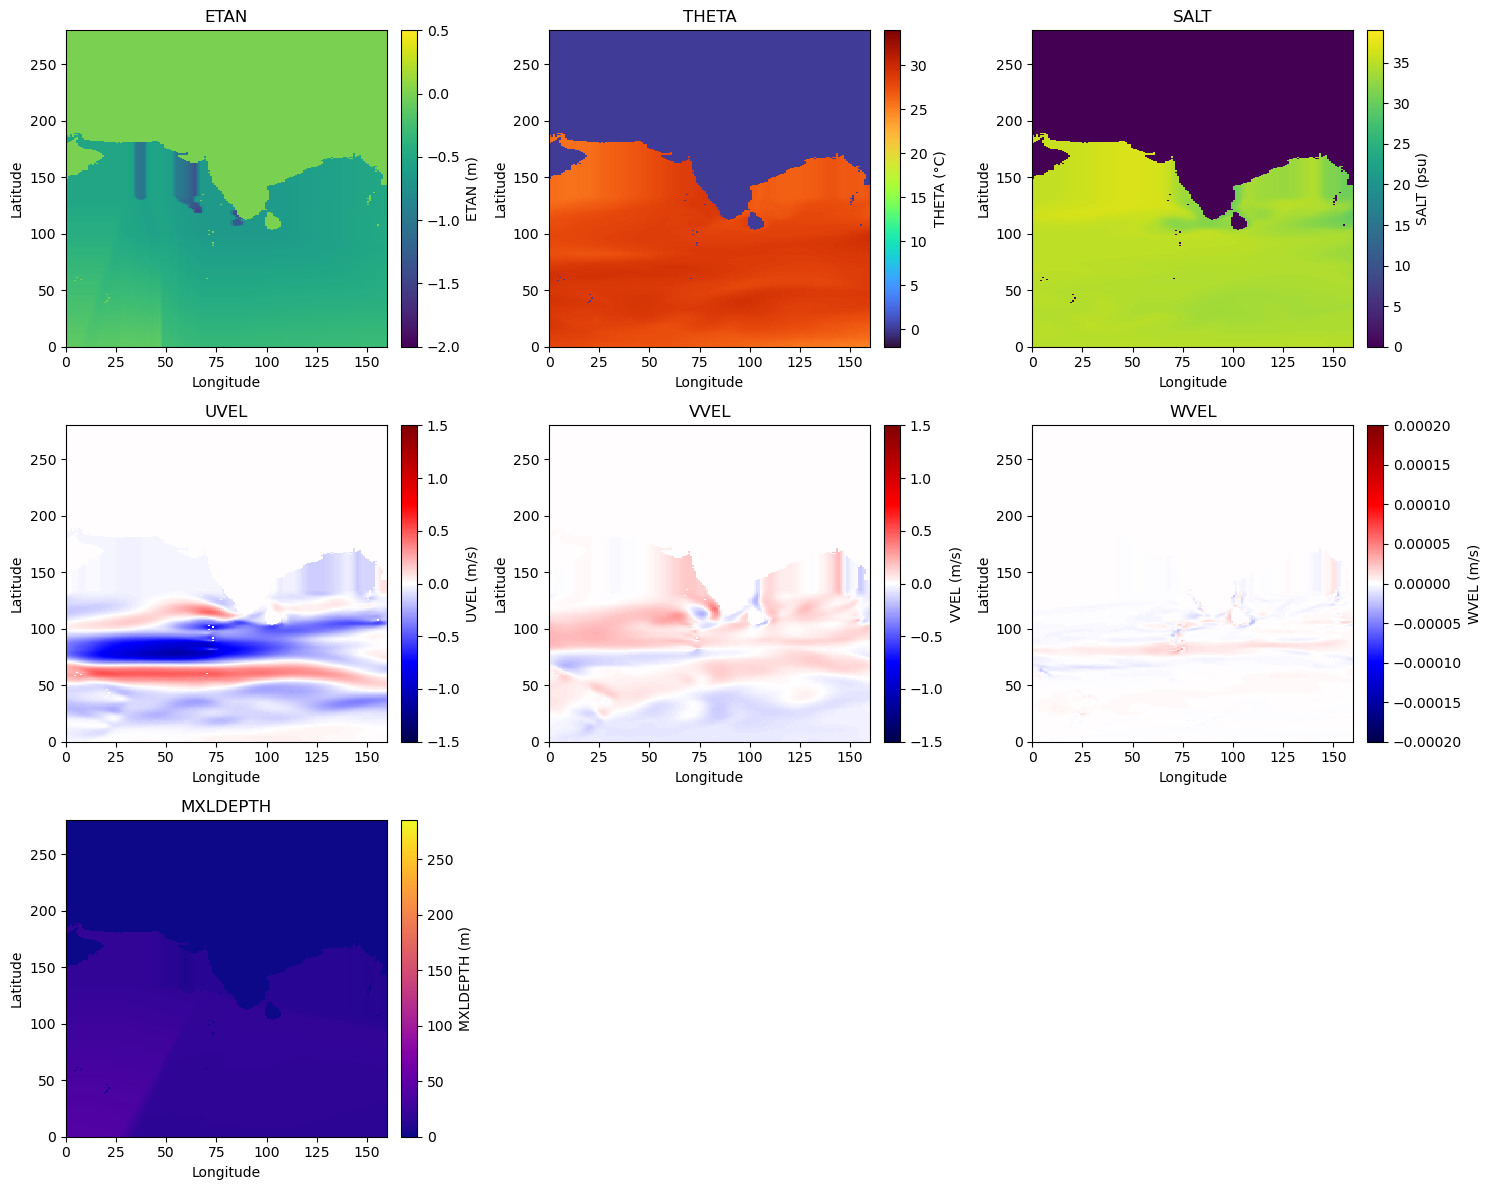

In [18]:
import math

variable_files = {
    'ETAN': 'ETAN_IC.bin',
    'THETA': 'THETA_IC.bin',
    'SALT': 'SALT_IC.bin',
    'UVEL': 'UVELMASS_IC.bin',
    'VVEL': 'VVELMASS_IC.bin',
    'WVEL': 'WVELMASS_IC.bin',
    'MXLDEPTH': 'MXLDEPTH_IC.bin'
}

ny, nx = 280, 160
nz = 50  

n_vars = len(variable_files)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, (var_name, filename) in enumerate(variable_files.items()):
    path = os.path.join(input_dir, filename)
    data = np.fromfile(path, dtype='>f4')

    if var_name in ['ETAN', 'MXLDEPTH']:
        data = data.reshape((ny, nx))
    else:
        data = data.reshape((nz, ny, nx))
        data = data[0, :, :]  # surface layer

    vmin, vmax, cmap, unit = meta_dict[var_name]

    ax = plt.subplot(n_rows, n_cols, i + 1)
    pcm = ax.pcolormesh(data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04, label=f"{var_name} ({unit})")
    ax.set_title(var_name)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()